In [1]:
import jax
import jax.numpy as jnp
from jax.scipy.stats import gaussian_kde
import numpy as np
import mcmc_infinity as mc
import matplotlib.pyplot as plt
import emcee
import corner

seed = 12345

# Target Distribution

Here we try to sample a $d=2$ dimensional Rosenbrock
banana function with log-PDF given by

$$ \log f(x) = -\sum_{i=1}^{d-1} ( 100 (x_{i+1}-x_{i}^2)^2 + (1-x_{i})^2 ) + c, $$

where $c$ is an unknown normalisation constant.

In [2]:
dim = 2

target = mc.test_functions.rosenbrock.Rosenbrock(dim=dim)

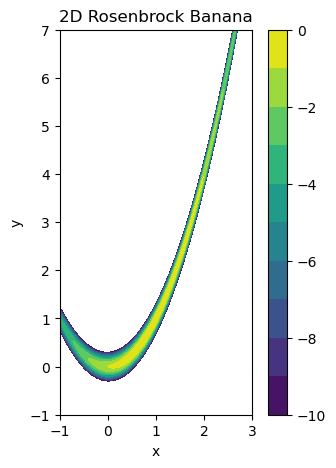

In [3]:
x = np.linspace(-1, 3, 300)
y = np.linspace(-1, 7, 300)
X, Y = np.meshgrid(x, y)
Z = target(np.stack((X,Y), axis=-1))

fig, ax = plt.subplots(figsize=(4,5))

levels = np.linspace(-10, 0, 11)
x = ax.contourf(X, Y, Z, levels=levels)
cbar = plt.colorbar(x)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("2D Rosenbrock Banana")
ax.set_aspect('equal')

plt.show()

# Proposal Distributions

We will experiment with several different proposal distributions.

 - __Uniform proposal__: We try a uniform proposal in the ranges $-1\leq x_0 \leq 3$ and $-1\leq x_1 \leq 7$.
 - __KDE proposal__: 




In [4]:
bounds = np.array([[-1.0, 3.0], [-1.0, 7.0]])

uniform_proposal = mc.uniform_proposal.UniformProposal(dim, bounds)

Mean acceptance fraction: 0.362
Mean autocorrelation time: 828.523


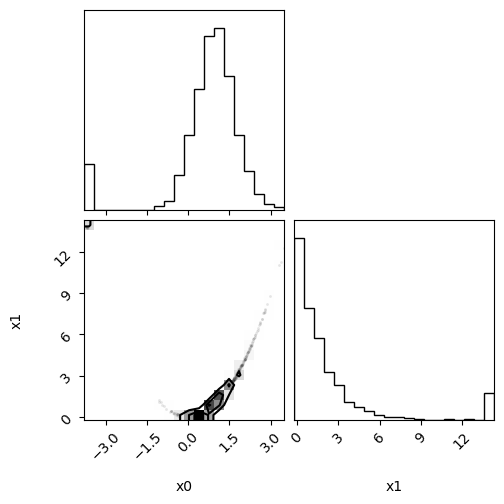

In [5]:
# initialise walker positions uniformly within the prior bounds
nwalkers = 20
x0 = np.random.uniform(size=(nwalkers, dim))
x0 = bounds[:,0] + x0 * (bounds[:,1] - bounds[:,0])

# initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, dim, target)

# run burn-in
sampler.run_mcmc(x0, 1000)
sampler.reset()

# run analysis chains 
sampler.run_mcmc(x0, 100000)
print(f"Mean acceptance fraction: {np.mean(sampler.acceptance_fraction):.3f}")
print(f"Mean autocorrelation time: {np.mean(sampler.get_autocorr_time()):.3f}")

samples = sampler.get_chain(flat=True, thin=2000)

corner.corner(samples, 
              labels=[f"x{i}" for i in range(dim)],
              ranges=[bounds[i] for i in range(dim)])

plt.show()


In [10]:
Qkde_small = mc.kde_proposal.KernelDensityEstimateProposal(dim, 
                 inflation_scale=2.0)
Qkde_small.fit(samples)

Qkde_big = mc.kde_proposal.KernelDensityEstimateProposal(dim, 
                 inflation_scale=10.0)
Qkde_big.fit(samples)

In [ ]:
sampler_uniform = mc.sampler.PerfectSampler(target, 
                                            uniform_proposal, 
                                            np.array([[1.]*dim]), 
                                            seed=seed)

sampler_kde_small = mc.sampler.PerfectSampler(target, 
                                            Qkde_small, 
                                            np.array([[1.]*dim]), 
                                            seed=seed)

sampler_kde_big = mc.sampler.PerfectSampler(target, 
                                            Qkde_big, 
                                            np.array([[1.]*dim]), 
                                            seed=seed)

In [13]:
T, num_samples = 4, 10

samples = sampler_uniform.get_perfect_samples(T, num_samples)

100%|██████████| 10/10 [00:04<00:00,  2.43it/s]
